In [1]:
import os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/CommonSwissBirds

/content/drive/MyDrive/CommonSwissBirds


In [4]:
%ls

01_data_prep/   04_resnet_50/         07_VGG16/                readme.ipynb
02_data/        05_efficientNetV2L/   08_custom_CNN/           utils/
03_base_model/  06_mobileNetV3_mini/  09_VGG16_original_head/


In [5]:
sys.path.append('./utils')
import utils

In [6]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 1
GPU 0: NVIDIA A100-SXM4-40GB (UUID: GPU-6152052c-5f56-eb57-348a-a190d10b099f)


In [7]:
class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.


In [9]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 5000 files belonging to 10 classes.
Using 1000 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/test_images',
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
)

Found 1222 files belonging to 10 classes.


In [11]:
showcase_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/showcase_images',
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    shuffle=False,
    image_size=(224, 224),
)

Found 30 files belonging to 10 classes.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
showcase_ds = showcase_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
num_classes = 10
#Build some random small model....
def createModel():
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'])
    return model
model = createModel()

In [14]:
callbacks = [EarlyStopping(monitor='val_accuracy', mode = "max", patience=2),
ModelCheckpoint(
    filepath=r'./03_base_model/model/best.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [15]:
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=50,
  callbacks=[callbacks],
)

Epoch 1/50
125/125 [==============================] - 96s 638ms/step - loss: 2.0651 - accuracy: 0.2655 - val_loss: 1.9480 - val_accuracy: 0.2960
Epoch 2/50
125/125 [==============================] - 2s 14ms/step - loss: 1.2561 - accuracy: 0.5842 - val_loss: 1.3348 - val_accuracy: 0.5770
Epoch 3/50
125/125 [==============================] - 2s 14ms/step - loss: 0.6598 - accuracy: 0.7990 - val_loss: 0.8436 - val_accuracy: 0.7870
Epoch 4/50
125/125 [==============================] - 2s 13ms/step - loss: 0.3468 - accuracy: 0.8975 - val_loss: 1.0080 - val_accuracy: 0.7820
Epoch 5/50
125/125 [==============================] - 2s 14ms/step - loss: 0.2241 - accuracy: 0.9342 - val_loss: 0.7917 - val_accuracy: 0.8080
Epoch 6/50
125/125 [==============================] - 2s 13ms/step - loss: 0.1372 - accuracy: 0.9592 - val_loss: 0.9872 - val_accuracy: 0.7840
Epoch 7/50
125/125 [==============================] - 2s 14ms/step - loss: 0.1251 - accuracy: 0.9690 - val_loss: 0.5319 - val_accuracy: 0.86

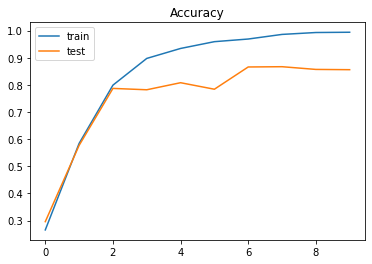

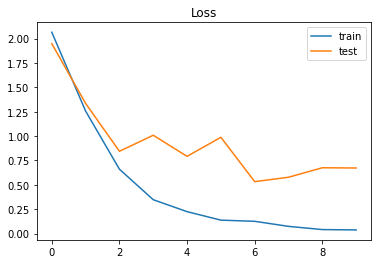

In [16]:
%matplotlib inline
utils.plot_history(history)

In [17]:
# Possible to start here without training... just loading the new weights...
model = createModel()
model.build(input_shape=(None,224,224,3))
model.load_weights('./03_base_model/model/best.h5')

In [18]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
39/39 [==============================] - 20s 496ms/step - loss: 1.5862 - accuracy: 0.7390
test loss, test acc: [1.5861701965332031, 0.7389525175094604]


In [19]:
testset_predictions = model.predict(test_ds)
print(testset_predictions)
print(testset_predictions.shape)

39/39 [==============================] - 0s 7ms/step
[[9.9995863e-01 5.1533959e-09 7.8429343e-07 ... 1.6723787e-05
  1.7017710e-05 1.1051401e-08]
 [9.9998236e-01 4.7592830e-10 4.8916149e-14 ... 1.2284453e-05
  4.6967667e-08 9.3447061e-10]
 [7.5861793e-03 2.9134711e-13 5.0771921e-15 ... 9.9241346e-01
  9.8327178e-08 1.8256515e-19]
 ...
 [1.9182527e-04 4.5003722e-07 1.2566741e-04 ... 5.2691058e-07
  3.9080976e-05 9.9763858e-01]
 [3.6050583e-04 2.9538898e-02 2.0995329e-03 ... 4.2679279e-05
  3.8457551e-04 9.6040469e-01]
 [3.1387004e-10 2.3331479e-09 8.7736159e-11 ... 9.0110106e-09
  1.8394852e-07 9.9999976e-01]]
(1222, 10)


In [20]:
testset_predictions = model.predict(test_ds)
predicted_labels = [prediction.argmax() for prediction in testset_predictions]
true_labels = utils.get_labels_from_int_batch_dataset(test_ds)
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

39/39 [==============================] - 0s 7ms/step


In [21]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       0.62      0.54      0.58       113
     blaumeise       0.72      0.73      0.73       125
      buchfink       0.77      0.82      0.80       125
        elster       0.90      0.81      0.86       113
hausrotschwanz       0.67      0.73      0.70       117
     hausspatz       0.74      0.76      0.75       133
     kohlmeise       0.88      0.61      0.72       125
   rabenkraehe       0.65      0.68      0.66       121
          star       0.88      0.83      0.86       125
  tuerkentaube       0.64      0.86      0.74       125

      accuracy                           0.74      1222
     macro avg       0.75      0.74      0.74      1222
  weighted avg       0.75      0.74      0.74      1222



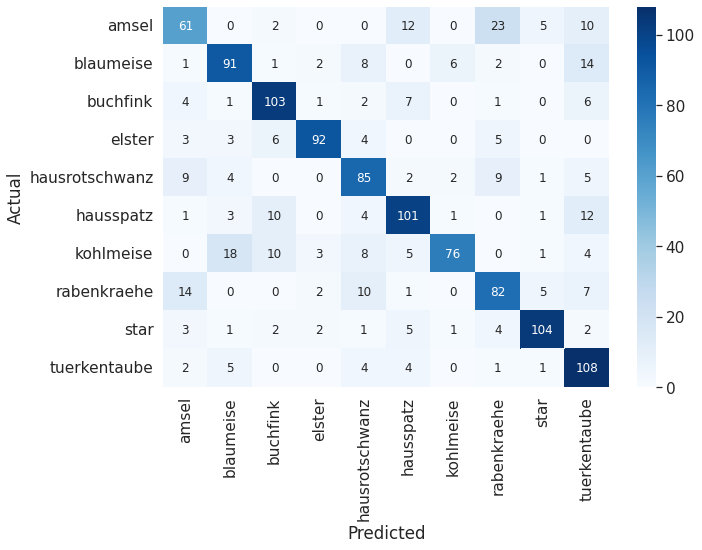

In [22]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

In [23]:
showcase_predictions = model.predict(showcase_ds)
predicted_labels = [prediction.argmax() for prediction in showcase_predictions]
true_labels = [label.numpy() for label in [labels for images, labels in showcase_ds.take(1)][0]]
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

1/1 [==============================] - 1s 572ms/step


In [24]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       0.67      0.67      0.67         3
     blaumeise       1.00      1.00      1.00         3
      buchfink       0.67      0.67      0.67         3
        elster       0.67      0.67      0.67         3
hausrotschwanz       0.67      0.67      0.67         3
     hausspatz       0.67      0.67      0.67         3
     kohlmeise       1.00      0.67      0.80         3
   rabenkraehe       0.60      1.00      0.75         3
          star       0.50      0.33      0.40         3
  tuerkentaube       1.00      1.00      1.00         3

      accuracy                           0.73        30
     macro avg       0.74      0.73      0.73        30
  weighted avg       0.74      0.73      0.73        30



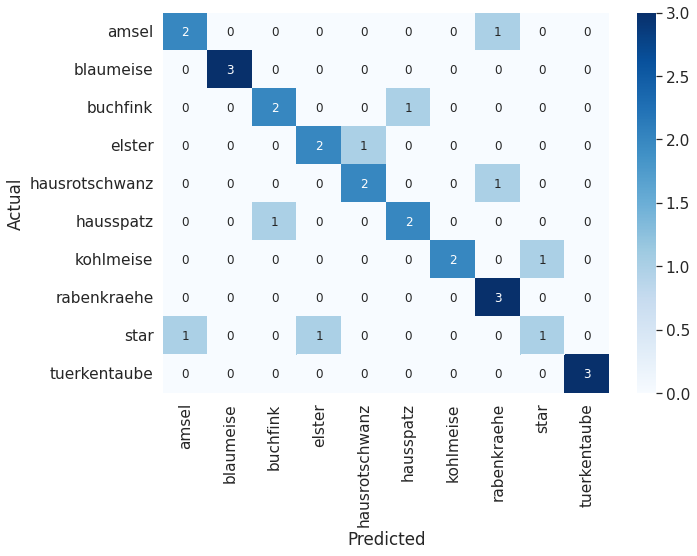

In [25]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

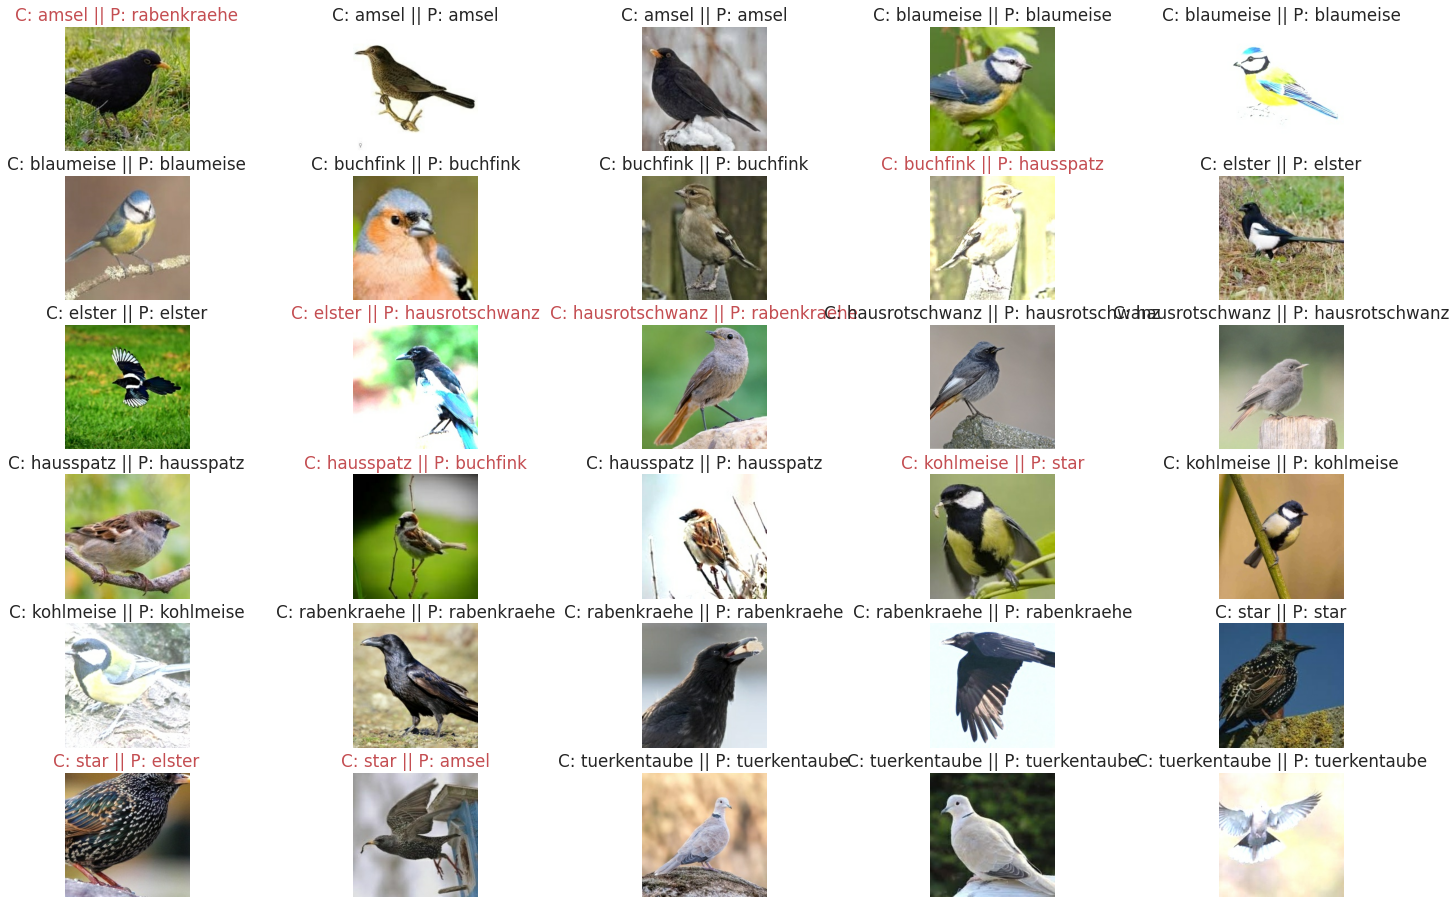

In [26]:
%matplotlib inline
utils.plot_showcase(showcase_ds, class_names, showcase_predictions)

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 32)       